In [1]:
%matplotlib inline
from src.pgm import draw, discretize, get_f1_score

import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianModel

In [2]:
df = pd.read_csv("dataset/diabetes.csv").astype({"Outcome": "category"})
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
df = discretize(kbd, df)
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


# Model uproszczony
Rozważamy tylko zmienne:
- Glucose
- Insulin
- SkinThickness
- Outcome

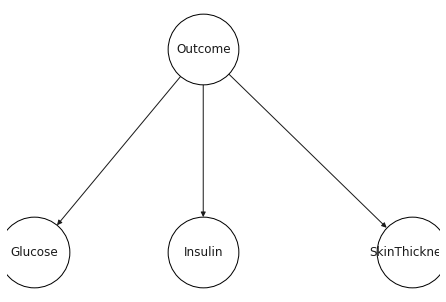

In [3]:
bn = BayesianModel([
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train[["Glucose", "Insulin", "SkinThickness", "Outcome"]])
draw(bn)

In [4]:
y_pred = bn.predict(test[["Glucose", "Insulin", "SkinThickness"]])
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 44/44 [00:02<00:00, 20.25it/s]
F1-score: 0.48
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        76
           1       0.51      0.45      0.48        40

    accuracy                           0.66       116
   macro avg       0.62      0.61      0.62       116
weighted avg       0.65      0.66      0.66       116



# Pełen model

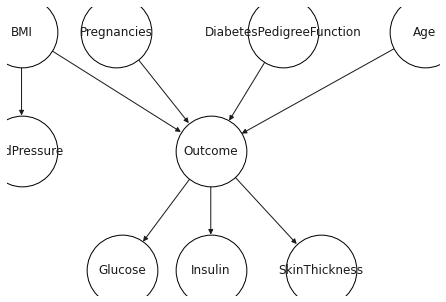

In [12]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)

In [6]:
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 115/115 [00:01<00:00, 59.00it/s]
F1-score: 0.58
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        76
           1       0.59      0.57      0.58        40

    accuracy                           0.72       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.72      0.71       116



# Poszukiwanie architektury grafu

  0%|          | 0/1000000 [00:00<?, ?it/s]


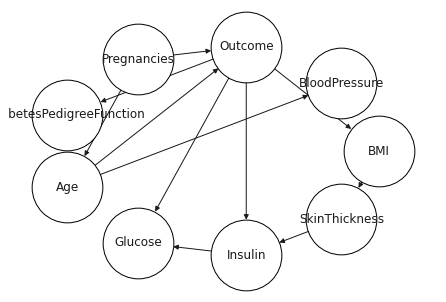

In [17]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score

skeleton_hc = HillClimbSearch(df).estimate(
    scoring_method=K2Score(df),
    start_dag=bn,
)
draw(skeleton_hc, layout="kamada_kawai_layout", scale=40);

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:07<00:01,  1.88s/it]


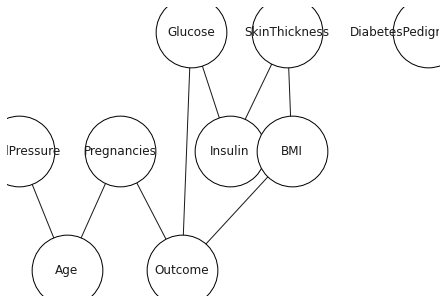

In [9]:
from pgmpy.estimators import PC
pc_est = PC(data=df)
skeleton_pc, separating_sets_pc = pc_est.build_skeleton(variant='parallel')
draw(skeleton_pc)